In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('simvision_pixel_TDC.csv', skiprows=1) ## Skip first row SimTime = 0

In [3]:
### Original column names
### 'SimTime',
### 'ETROC2_tb.ETROC2_inst.PixelMatrix_HTree_inst.PixelCol_inst_1.Pixel_inst_2.PixelAnalog_inst.TDC_CAL[9:0]'
### 'ETROC2_tb.ETROC2_inst.PixelMatrix_HTree_inst.PixelCol_inst_1.Pixel_inst_2.PixelAnalog_inst.TDC_TOA[9:0]'
### 'ETROC2_tb.ETROC2_inst.PixelMatrix_HTree_inst.PixelCol_inst_1.Pixel_inst_2.PixelAnalog_inst.TDC_TOT[8:0]'
### 'ETROC2_tb.ETROC2_inst.PixelMatrix_HTree_inst.PixelCol1_inst_14.Pixel1_inst_14.PixelAnalog1_inst.TDC_CAL[9:0]'
### 'ETROC2_tb.ETROC2_inst.PixelMatrix_HTree_inst.PixelCol1_inst_14.Pixel1_inst_14.PixelAnalog1_inst.TDC_TOA[9:0]'
### 'ETROC2_tb.ETROC2_inst.PixelMatrix_HTree_inst.PixelCol1_inst_14.Pixel1_inst_14.PixelAnalog1_inst.TDC_TOT[8:0]'

### Replace column names (only when TDC file has been opened)
df.columns = ['SimTime', 'Row1Col2_TDC_CAL', 'Row1Col2_TDC_TOA', 'Row1Col2_TDC_TOT', 
              'Row14Col14_TDC_CAL', 'Row14Col14_TDC_TOA', 'Row14Col14_TDC_TOT']

In [4]:
df.head()

,SimTime,Row1Col2_TDC_CAL,Row1Col2_TDC_TOA,Row1Col2_TDC_TOT,Row14Col14_TDC_CAL,Row14Col14_TDC_TOA,Row14Col14_TDC_TOT
0,182878305000,0A0,1AA,36,0A0,1AA,36
1,245727585000,0A0,1B4,41,0A0,1B5,42
2,3713706600000,0A0,1B4,41,0A0,1B5,42


In [5]:
### Covert hex to decimal
row1col2_cal = df['Row1Col2_TDC_CAL'].squeeze()
row1col2_toa = df['Row1Col2_TDC_TOA'].squeeze()
b16 = lambda x: int(x, 16)
row1col2_cal = row1col2_cal.apply(b16)
row1col2_toa = row1col2_toa.apply(b16)

Text(0, 0.5, 'TOT code')

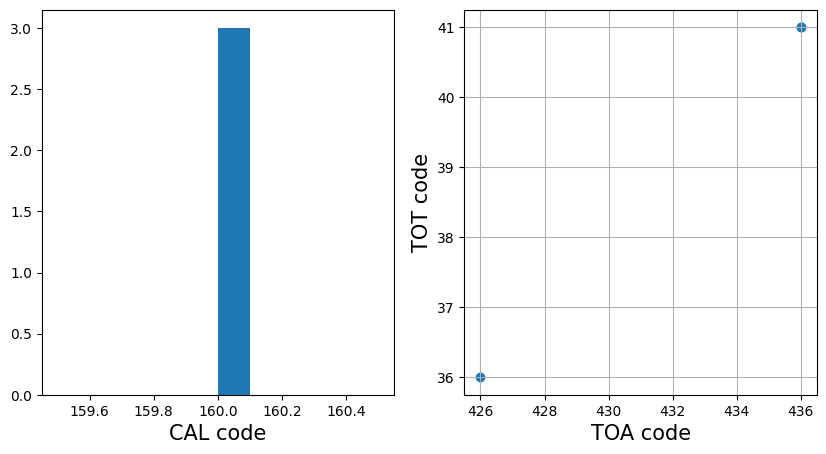

In [6]:
### plotting
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(row1col2_cal)
ax1.set_xlabel('CAL code', fontsize=15)

ax2.scatter(row1col2_toa, df['Row1Col2_TDC_TOT'])
ax2.grid()
ax2.set_xlabel('TOA code', fontsize=15)
ax2.set_ylabel('TOT code', fontsize=15)

In [7]:
### Covert hex to decimal
row14col14_cal = df['Row14Col14_TDC_CAL'].squeeze()
row14col14_toa = df['Row14Col14_TDC_TOA'].squeeze()
row14col14_cal = row14col14_cal.apply(b16)
row14col14_toa = row14col14_toa.apply(b16)

Text(0, 0.5, 'TOT code')

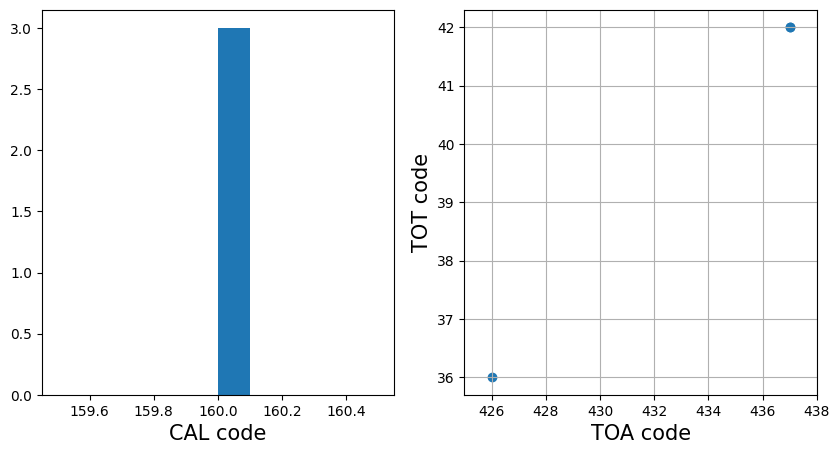

In [8]:
### plotting
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.hist(row14col14_cal)
ax1.set_xlabel('CAL code', fontsize=15)

ax2.scatter(row14col14_toa, df['Row14Col14_TDC_TOT'])
ax2.grid()
ax2.set_xlim(425, 438)
ax2.set_xlabel('TOA code', fontsize=15)
ax2.set_ylabel('TOT code', fontsize=15)

In [9]:
df2 = pd.read_csv('simvision_fastcmd_data.csv', skiprows=1)

In [10]:
### Original column names
### 'SimTime' 
### 'ETROC2_tb.FCGenLocal_inst.FastComByte[7:0]'

### Replace column names (only when fast command file has been opened)
df2.columns = ['SimTime', 'FastComByte']

In [11]:
df2['FastComByte']
### F0 (1111 0000): Idle
### 69 (0110 1001): Charge injection
### 5A (0101 1010): BCR (Bunch counter reset at BC0, reset the counter to zero)
### 96 (1001 0110): L1A
### Reference: https://indico.cern.ch/event/1127562/contributions/4904781/attachments/2454504/4319592/ETROCemulator%20slides20220921.pdf

0     F0
1     69
2     F0
3     69
4     F0
5     5A
6     F0
7     69
8     F0
9     96
10    F0
11    F0
Name: FastComByte, dtype: object

In [12]:
### create a list of our conditions
conditions = [
    (df2['FastComByte'] == 'F0'),
    (df2['FastComByte'] == '69'),
    (df2['FastComByte'] == '5A'),
    (df2['FastComByte'] == '96')
    ]

### create a list of the values we want to assign for each condition
values = ['Idle', 'Charge injection', 'BCR', 'L1A']

### create a new column and use np.select to assign values to it using our lists as arguments
df2['fcmd_defn'] = np.select(conditions, values)

### display updated DataFrame
print(df2)

          SimTime FastComByte         fcmd_defn
0        24960000          F0              Idle
1    182232960000          69  Charge injection
2    182257920000          F0              Idle
3    182757120000          69  Charge injection
4    182782080000          F0              Idle
5    245182080000          5A               BCR
6    245207040000          F0              Idle
7    245606400000          69  Charge injection
8    245631360000          F0              Idle
9    257612160000          96               L1A
10   258735360000          F0              Idle
11  3579313600000          F0              Idle


In [ ]:
### Under develop
df3 = pd.read_csv('simvision.csv')

In [ ]:
df3.head()

In [ ]:
### 3C5C pattern recognition
### Only check whether the data has 3C5C pattern at anywhere or not
### 3 C 5 C (hex)
### 0011 1100 0101 1100 (binary)
pattern = [0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0]

matched = df3.rolling(len(pattern)).apply(lambda x: all(np.equal(x, pattern)), raw=True)
matched = matched.sum(axis = 1).astype(bool)   #Sum to perform boolean OR
idx_matched = np.where(matched)[0]
subset = [range(match-len(pattern)+1, match+1) for match in idx_matched]

In [ ]:
### 6AF3 pattern
### 6 A F 3
### 0110 1010 1111 0011